In [32]:
import numpy as np
import pandas as pd

from pathlib import Path
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
import soundfile as sf
import librosa

In [5]:
df = pd.read_csv('/home/lolik/kaggle/birds/birds-2023/train_metadata.csv')

target_columns = df.primary_label.unique().tolist()
len(target_columns)

264

In [6]:
idx = 10

sample = df.loc[idx, :]
wav_name = sample["filename"]
ebird_code = sample["primary_label"]

In [8]:
data_folder = Path("/home/lolik/kaggle/birds/birds-2023/train_audio")
y, sr = sf.read(data_folder / wav_name)
y

array([ 8.11895643e-06, -3.56813507e-05,  3.54409485e-06, ...,
       -2.70717638e-03, -1.43859244e-03, -4.06553096e-04])

In [74]:
sr * 20

640000

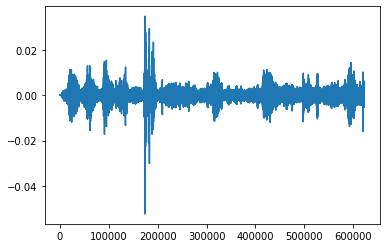

In [12]:
plt.plot(y)

In [13]:
from torchlibrosa.stft import LogmelFilterBank, Spectrogram
from torchlibrosa.augmentation import SpecAugmentation

period = 20
n_mels = 128
fmin = 20
fmax = 16000
n_fft = 2048
hop_length = 512
sample_rate = 32000
melspectrogram_parameters = {
    "n_mels": 224,
    "fmin": 20,
    "fmax": 16000
}


spectrogram_extractor = Spectrogram(n_fft=n_fft, hop_length=hop_length,
                                    win_length=n_fft, window="hann", center=True,
                                    pad_mode="reflect", freeze_parameters=True)

# Logmel feature extractor
logmel_extractor = LogmelFilterBank(sr=sample_rate, n_fft=n_fft,
                                    n_mels=n_mels, fmin=fmin, fmax=fmax, ref=1.0,
                                    amin=1e-10, top_db=None, freeze_parameters=True)

In [15]:
y.shape

(622848,)

In [97]:
class WaveformDataset(Dataset):
    def __init__(self,
                 df: pd.DataFrame,
                 datadir: Path,
                 img_size=224,
                 waveform_transforms=None,
                 period=20,
                 validation=False):
        self.df = df
        self.datadir = datadir
        self.img_size = img_size
        self.waveform_transforms = waveform_transforms
        self.period = period
        self.validation = validation

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        sample = self.df.loc[idx, :]
        wav_name = sample["filename"]
        # ebird_code = sample["primary_label"]

        y, sr = sf.read(self.datadir / wav_name)

        len_y = len(y)
        effective_length = sr * self.period
        if len_y < effective_length:
            new_y = np.zeros(effective_length, dtype=y.dtype)
            if not self.validation:
                start = np.random.randint(effective_length - len_y)
            else:
                start = 0
            new_y[start:start + len_y] = y
            y = new_y.astype(np.float32)
        elif len_y > effective_length:
            if not self.validation:
                start = np.random.randint(len_y - effective_length)
            else:
                start = 0
            y = y[start:start + effective_length].astype(np.float32)
        else:
            y = y.astype(np.float32)

        y = np.nan_to_num(y)

        if self.waveform_transforms:
            y = self.waveform_transforms(y)

        y = np.nan_to_num(y)

        # labels = np.zeros(len(CFG.target_columns), dtype=float)
        # labels[CFG.target_columns.index(ebird_code)] = 1.0

        return {
            "image": y,
            # "targets": labels
        }

In [98]:
def get_transforms(phase: str):
    transforms = {
        "train": [{"name": "Normalize"}],
        "valid": [{"name": "Normalize"}]
    }
    if transforms is None:
        return None
    else:
        if transforms[phase] is None:
            return None
        trns_list = []
        for trns_conf in transforms[phase]:
            trns_name = trns_conf["name"]
            trns_params = {} if trns_conf.get("params") is None else \
                trns_conf["params"]
            if globals().get(trns_name) is not None:
                trns_cls = globals()[trns_name]
                trns_list.append(trns_cls(**trns_params))

        if len(trns_list) > 0:
            return Compose(trns_list)
        else:
            return None
        
        
class Normalize:
    def __call__(self, y: np.ndarray):
        max_vol = np.abs(y).max()
        y_vol = y * 1 / max_vol
        return np.asfortranarray(y_vol)


class Compose:
    def __init__(self, transforms: list):
        self.transforms = transforms

    def __call__(self, y: np.ndarray):
        for trns in self.transforms:
            y = trns(y)
        return y

In [99]:
dataset = WaveformDataset(df, data_folder, get_transforms("train"))

In [100]:
from_dataset = dataset[0]['image'][None]
y, sr = sf.read(data_folder / wav_name)
tr = get_transforms("train")

y = tr(y)
y = np.nan_to_num(y)

y.shape, from_dataset.shape

len_y > effictive


((622848,), (1, 640000))

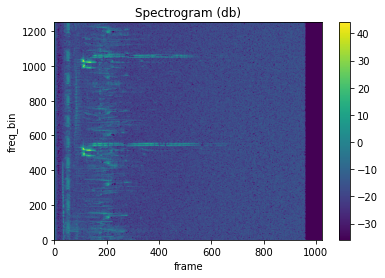

In [88]:

spectr = spectrogram_extractor(torch.tensor(dataset[0]['image'][None]))[0,0]
plot_spectrogram(spectr)

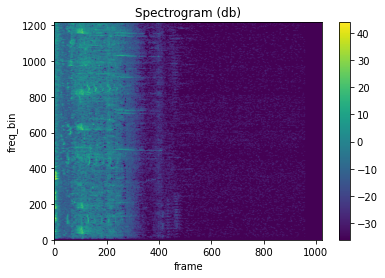

In [85]:
y, sr = sf.read(data_folder / wav_name)
y = Normalize()(y)
spectr = spectrogram_extractor(torch.tensor(y, dtype=torch.float32)[None])[0, 0]

plot_spectrogram(spectr)

In [57]:
from torchlibrosa.stft import LogmelFilterBank, Spectrogram
from torchlibrosa.augmentation import SpecAugmentation

period = 20
n_mels = 128
fmin = 20
fmax = 16000
n_fft = 2048
hop_length = 512
sample_rate = 32000
melspectrogram_parameters = {
    "n_mels": 224,
    "fmin": 20,
    "fmax": 16000
}


spectrogram_extractor = Spectrogram(n_fft=n_fft, hop_length=hop_length,
                                    win_length=n_fft, window="hann",
                                      center=True,
                                    pad_mode="reflect", freeze_parameters=True)

# Logmel feature extractor
logmel_extractor = LogmelFilterBank(sr=sample_rate, n_fft=n_fft,
                                    n_mels=n_mels, fmin=fmin, fmax=fmax, ref=1.0,
                                    amin=1e-10, top_db=None, freeze_parameters=True)

In [58]:
import torch

def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [59]:
dataset[0]['image'].shape

(640000,)

In [60]:
spectrogram_extractor(torch.tensor(dataset[0]['image'][None])).shape

torch.Size([1, 1, 1251, 1025])

torch.Size([1251, 1025])


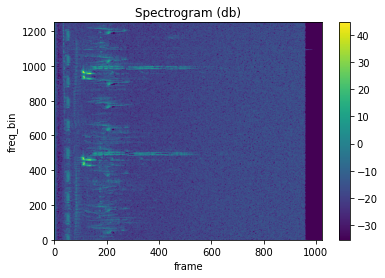

In [61]:
spectr = spectrogram_extractor(torch.tensor(dataset[0]['image'][None]))[0, 0, :, :]
print(spectr.shape)
plot_spectrogram(spectr)

In [66]:
import torchaudio

torchaudio.set_audio_backend(backend="soundfile")
print(torchaudio.get_audio_backend())

period = 20
n_mels = 128
fmin = 20
fmax = 16000
n_fft = 2048
hop_length = 512
sample_rate = 32000

transform = torchaudio.transforms.Spectrogram(
    n_fft=n_fft,
    win_length=2048,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    # power=2.0,
    # freeze_parameters=True
)

soundfile


In [67]:
data_folder / dataset.df.iloc[0]["filename"]

PosixPath('/home/lolik/kaggle/birds/birds-2023/train_audio/abethr1/XC128013.ogg')

torch.Size([1025, 1251])


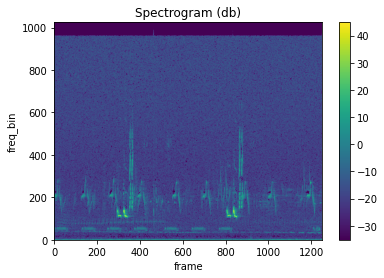

In [70]:
waveform, sample_rate = torchaudio.load(data_folder / dataset.df.iloc[0]["filename"])
waveform = torch.tensor(dataset[0]['image'][None])
spectrogram = transform(waveform)[0]
print(spectrogram.shape)
plot_spectrogram(spectrogram)

In [71]:
sample_rate

32000

In [73]:
len(waveform[0])

640000

In [1]:
import numpy as np
import cv2
import librosa
import glob
import soundfile as sf
import matplotlib.pyplot as plt
from albumentations import BasicTransform, DualTransform


class AudioTransform(BasicTransform):
    """ Transform for audio task. This is the main class where we override the targets and update params function for our need"""

    @property
    def targets(self):
        return {"data": self.apply}
    
    def update_params(self, params, **kwargs):
        if hasattr(self, "interpolation"):
            params["interpolation"] = self.interpolation
        if hasattr(self, "fill_value"):
            params["fill_value"] = self.fill_value
        return params


class AudioMinMaxNormalize(AudioTransform):
    def __init__(self, always_apply=False, p=1.0):
        super().__init__(always_apply, p)

    def apply(self, data, **params):
        max_vol = np.abs(data).max()
        data = data * 1 / max_vol
        return np.asfortranarray(data)

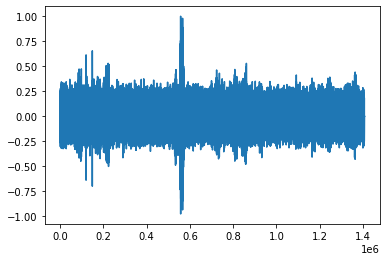

In [2]:
normalize = AudioMinMaxNormalize(p=1.0)
y, sr = sf.read('/home/lolik/kaggle/birds/birds-2023/train_audio/afrgrp1/XC126604.ogg')

plt.plot(normalize(data=y)['data'])

In [36]:
normalize = AudioMinMaxNormalize(p=1.0)

y, sr = sf.read('/home/lolik/kaggle/birds/birds-2023/train_audio/afrgrp1/XC126604.ogg')

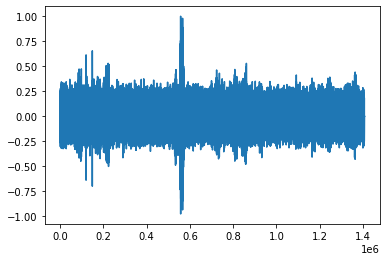

In [37]:
plt.plot(np.asfortranarray(y / np.abs(y).max()))

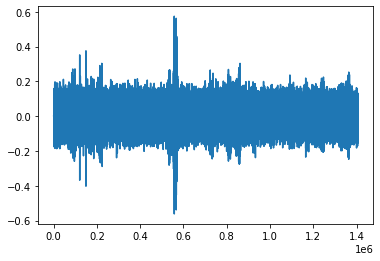

In [38]:
plt.plot(y)

In [39]:
np.max(normalize(image=y)['image'])

0.5745564699172974

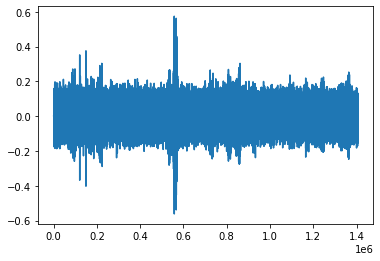

In [28]:
plt.plot(normalize(image=y)['image'])